<a href="https://colab.research.google.com/github/rafael-ariascalles/MachineLearningExamples/blob/main/Liability_Customer_Buying_Loans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Business Objective

Predict the likelihood of a liability customer buying personal loans

Steps and tasks:
* Import the datasets and libraries, check datatype, statistical summary, shape, null values or incorrect imputation. (5 marks)

* Split the data into training and test set in the ratio of 70:30 respectively (5 marks)
* Use the Logistic Regression model to predict whether the customer will take a personal loan or not. Print all the metrics related to evaluating the model performance (accuracy, recall, precision, f1score, and roc_auc_score). Draw a heatmap to display confusion matrix (15 marks)
* Find out coefficients of all the attributes and show the output in a data frame with column names? For test data show all the rows where the predicted class is not equal to the observed class. (10 marks)
* Give conclusion related to the Business understanding of your model? (5 marks)

## Libraries

In [ ]:
import pandas as pd
import numpy as np
#import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

## Data Understanding

Attribute Information:
* ID: Customer ID 
* Age NUM: Customer's age in completed years
* Experience NUM: #years of professional experience
* Income NUM: Annual income of the customer K
* ZIP Code CATE: Home Address ZIP
* Family CATE: Family size of the customer
* CCAvg NUM: Avg. spending on credit cards per month k
* Education CATE: Education Level. 1: Undergrad; 2: Graduate; 3: Advanced/Professional
* Mortgage NUM: Value of house mortgage if any. k
* Personal Loan TARGET: Did this customer accept the personal loan offered in the last campaign?
* Securities Account BOOL: Does the customer have a securities account with the bank?
* CD Account BOOL: Does the customer have a certificate of deposit (CD) account with the bank?
* Online BOOL: Does the customer use internet banking facilities?
* Credit card BOOL: Does the customer use a credit card issued by the bank?

In [ ]:
data = pd.read_csv("drive/MyDrive/PGP-AIML/Bank_Personal_Loan_Modelling.csv")

Columns names normalize to lower and replace space with underscore

In [ ]:
data.columns = [s.lower().replace(" ","_") for s in data.columns]

In [ ]:
data.head()

,id,age,experience,income,zip_code,family,ccavg,education,mortgage,personal_loan,securities_account,cd_account,online,creditcard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [ ]:
data.columns

Index(['id', 'age', 'experience', 'income', 'zip_code', 'family', 'ccavg',
       'education', 'mortgage', 'personal_loan', 'securities_account',
       'cd_account', 'online', 'creditcard'],
      dtype='object')

In [ ]:
data.shape

(5000, 14)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   experience          5000 non-null   int64  
 3   income              5000 non-null   int64  
 4   zip_code            5000 non-null   int64  
 5   family              5000 non-null   int64  
 6   ccavg               5000 non-null   float64
 7   education           5000 non-null   int64  
 8   mortgage            5000 non-null   int64  
 9   personal_loan       5000 non-null   int64  
 10  securities_account  5000 non-null   int64  
 11  cd_account          5000 non-null   int64  
 12  online              5000 non-null   int64  
 13  creditcard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [ ]:
data.describe()

,id,age,experience,income,zip_code,family,ccavg,education,mortgage,personal_loan,securities_account,cd_account,online,creditcard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


Different preprocessing will be use for ZIP Code, Family, Education. These variable represent a Discrite information or a category information.

ID will be drop.

With Expirience feature it will be "Clip" to have a range between 1 to Max, rigth now we have -3 as minimun. we are going to transform every number less than 1 in 1 .

Age, Income, CCavg and  Mortgage will be use as is. only that it will be generated a Flag if the Mortgage column is 0, indicating if the customer has a Mortage.

For binary variables it will be use as is.

the Number 1 in Family,Education will be the base class of the model. 

For the ZIP Code, it will be take the first 2 digits and create dummy variable. and it only be use the top 4 Zip codes and then the base class will be the rest of the Zip Code

# Data Exploration (EDA)

* EDA: Study the data distribution in each attribute and target variable, share your findings (20 marks) 
  * Number of unique in each column?
  * Number of people with zero mortgage?
  * Number of people with zero credit card spending per month?
  * Value counts of all categorical columns.
 Univariate and Bivariate
 Get data model ready

#### Unique values in the dataset

In [ ]:
print("Unique values:")
data.nunique()

Unique values:


id                    5000
age                     45
experience              47
income                 162
zip_code               467
family                   4
ccavg                  108
education                3
mortgage               347
personal_loan            2
securities_account       2
cd_account               2
online                   2
creditcard               2
dtype: int64

In [ ]:
data["zip_code"].apply(lambda x: str(x)[:2]).nunique()

7

As the ZIP code is a Categorical Variable given that it doesnt have a Numeric interpretation, it would be group in ZIP codes of 2 digits to have a category. in that way we will be only using 7 Codes for location

In [ ]:
data["zip_code"].apply(lambda x: str(x)[:2]).value_counts()

94    1472
92     988
95     815
90     703
91     565
93     417
96      40
Name: zip_code, dtype: int64

#### Histogram of Variables

In [ ]:
#Variable Creation
data["zip2d"] = data["zip_code"].apply(lambda x: str(x)[:2])

In [ ]:
n = len(data.columns)

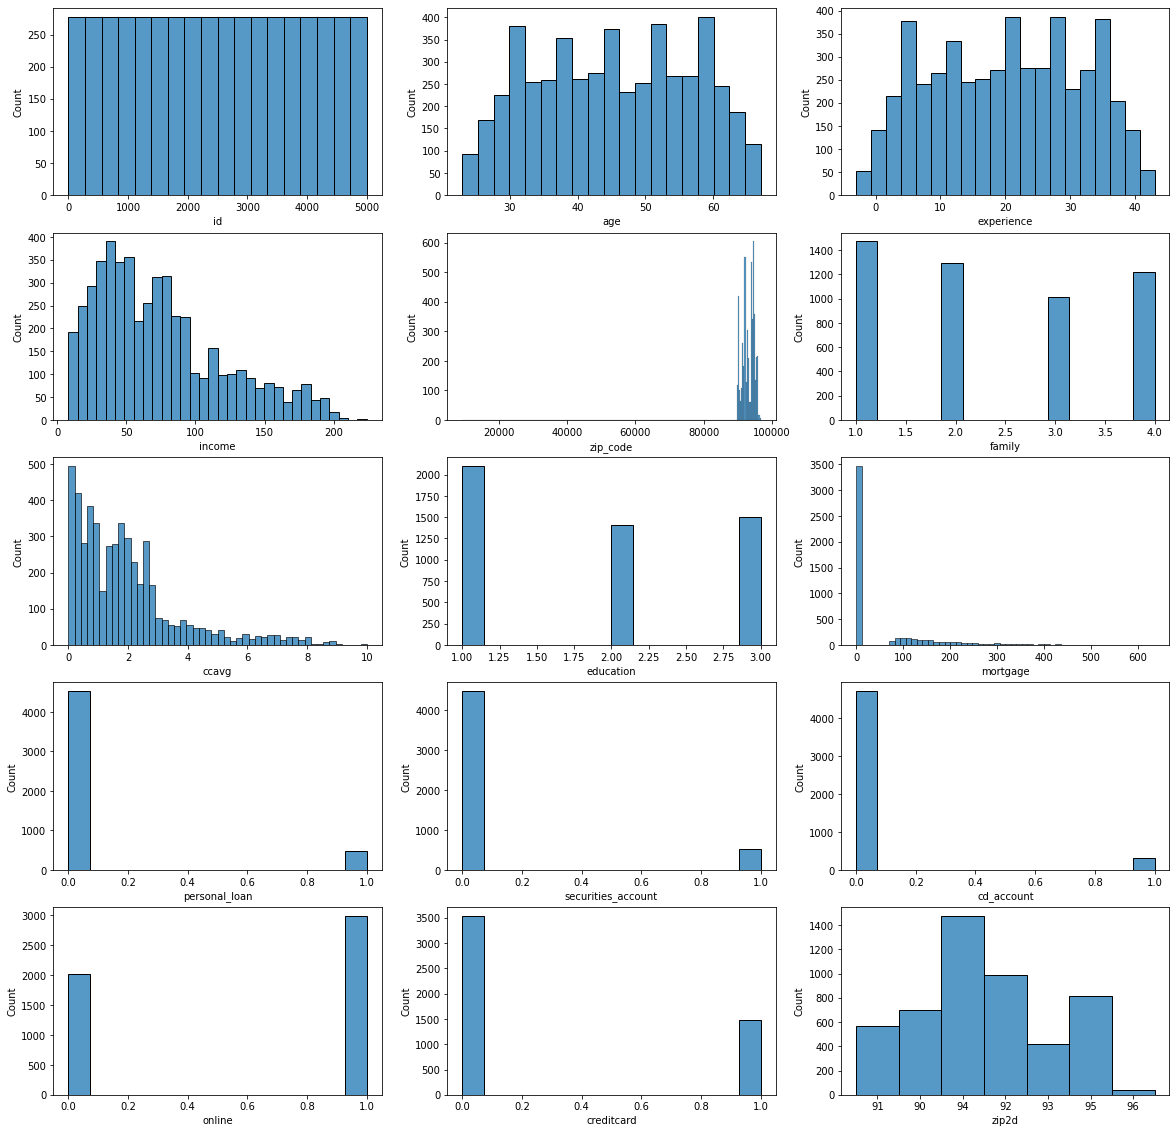

In [ ]:
fig, axs = plt.subplots(n//3,3,figsize=(20,20))
axs = axs.flatten()
for c,ax in zip(data,axs):
  sns.histplot(data[c],ax=ax)
plt.show()

As show above, the variables CreditCard, Online, CD ACCount, Securities Account, Education , Family and ZIP2D will be use as Categorical Variables. also the variable got_mortgage would be created to have the different bewteen customer with and without mortgage. In other words. the categorical variables would be all the variables with less than 7 unique values . ID it wont be use

In [ ]:
data.drop(["id","zip_code"],axis=1,inplace=True)

#### Definition of variable type

In [ ]:
#Variable Creation
data["got_mortgage"] = np.array(data.mortgage > 0,dtype=np.int)

In [ ]:
target = "personal_loan"

In [ ]:
categorical_variables = np.array(data.drop(target,1).columns[data.drop(target,1).nunique().values <= 7])

In [ ]:
numeric_variables = np.array(data.columns[data.nunique().values > 7])

In [ ]:
data[categorical_variables].head()

,family,education,securities_account,cd_account,online,creditcard,zip2d,got_mortgage
0,4,1,1,0,0,0,91,0
1,3,1,1,0,0,0,90,0
2,1,1,0,0,0,0,94,0
3,1,2,0,0,0,0,94,0
4,4,2,0,0,0,1,91,0


In [ ]:
data[numeric_variables].head()

,age,experience,income,ccavg,mortgage
0,25,1,49,1.6,0
1,45,19,34,1.5,0
2,39,15,11,1.0,0
3,35,9,100,2.7,0
4,35,8,45,1.0,0


In [ ]:
data[target].head()

0    0
1    0
2    0
3    0
4    0
Name: personal_loan, dtype: int64

In [ ]:
#TODO: Pair plot of Numerica and something similar of pairplot to Categorical and Heatmap Correlation
familyEnc = OneHotEncoder(drop="first")
educationEnc = OneHotEncoder(handle_unknown='ignore',drop="first")
securitiesEnc = OneHotEncoder(handle_unknown='ignore',drop="first")
cdEnc = OneHotEncoder(handle_unknown='ignore',drop="first")
onlineEnc = OneHotEncoder(handle_unknown='ignore',drop="first")
creditcardEnc = OneHotEncoder(handle_unknown='ignore',drop="first")
zip2d = OneHotEncoder(handle_unknown='ignore',drop="first")

In [ ]:
familyEnc.fit_transform(data[categorical_variables[0]].to_numpy().reshape(-1,1)).toarray()

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

TypeError: ignored

## Data Pre processing

## Modeling

## Model Evaluation

## Business Insights